In [317]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [318]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [20, 9]
plt.rcParams['lines.linewidth'] = 1

In [319]:
df = pd.read_csv("data/processed_dataset/dataset.csv")
df = df.set_index('Date')
df

,Open,High,Low,Close,Adj Close,Volume,Sentiment Score
Date,,,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300,0.413400
2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100,0.413400
2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800,0.413400
2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800,0.413400
2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900,0.413400
...,...,...,...,...,...,...,...
2019-12-24,418.359985,425.470001,412.690002,425.250000,425.250000,8054700,0.212657
2019-12-26,427.910004,433.480011,426.350006,430.940002,430.940002,10633900,0.225565
2019-12-27,435.000000,435.309998,426.109985,430.380005,430.380005,9945700,-0.439450


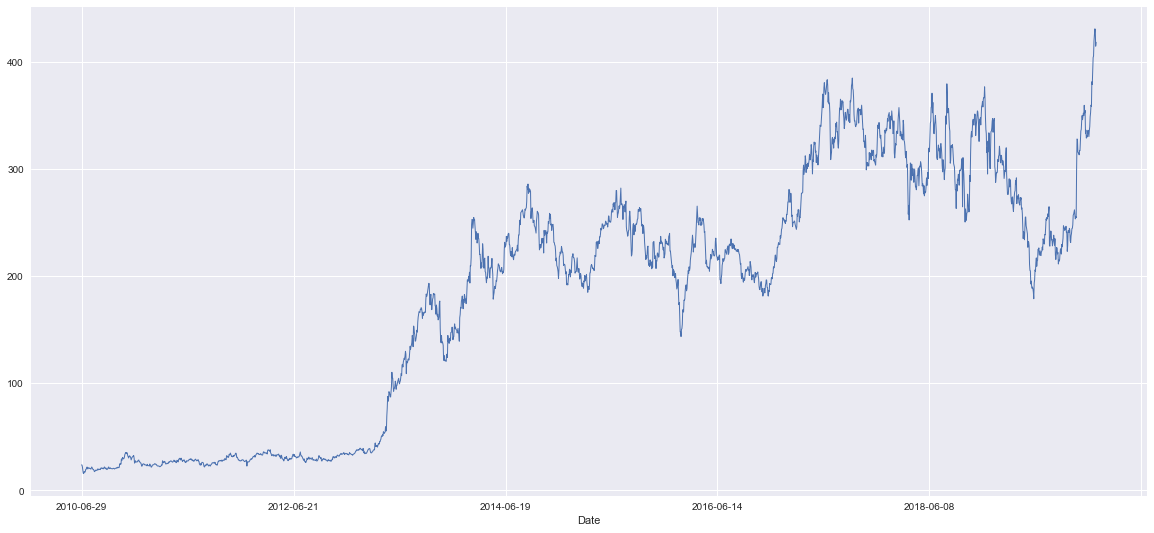

In [320]:
df['Close'].plot()
plt.show()

In [321]:
def get_rsi(df):
    
    diff = df.Close.diff().dropna()
    plus = diff.map(lambda x: x if x > 0 else 0).rename('Plus')
    minus = diff.map(lambda x: -1*x if x < 0 else 0).rename('Minus')

    temp = pd.concat([diff , plus, minus], axis = 1)
    temp['AvgUP'] = temp.Plus[:14].sum() / 14
    temp['AvgDOWN'] = temp.Minus[:14].sum() / 14


    for i in range(14, temp.Close.size):
        temp['AvgUP'].iloc[i] = (temp['Plus'].iloc[i] + 13*temp['AvgUP'].iloc[i-1]) / 14
        temp['AvgDOWN'].iloc[i] = (temp['Minus'].iloc[i] + 13*temp['AvgDOWN'].iloc[i-1]) / 14

    temp['RSI'] = 100 - (100 / (1 + temp['AvgUP'] / temp['AvgDOWN']))
    
    return [np.nan] + temp['RSI'].tolist()


In [322]:
def get_macd(df, short, long):
    ema_short = df.Close.ewm(span=short, adjust=False).mean()
    ema_long = df.Close.ewm(span=long, adjust=False).mean()
    macd_line = ema_short - ema_long
    
    return macd_line.tolist()

In [323]:
df['LogReturn'] = np.log(df['Close']).shift(-1) - np.log(df['Close']) # Calculate log return
df['RSI14'] = get_rsi(df)
short = 20
long = 200
df['MACD'] = get_macd(df, short,long)
df['Intermediate Momentum'] = df.Close.diff(60)

In [324]:
df

,Open,High,Low,Close,Adj Close,Volume,Sentiment Score,LogReturn,RSI14,MACD,Intermediate Momentum
Date,,,,,,,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300,0.413400,-0.002515,NaN,0.000000,NaN
2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100,0.413400,-0.081723,39.206254,-0.005117,NaN
2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800,0.413400,-0.134312,39.206254,-0.169184,NaN
2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800,0.413400,-0.175470,39.206254,-0.551383,NaN
2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900,0.413400,-0.019430,39.206254,-1.156758,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,418.359985,425.470001,412.690002,425.250000,425.250000,8054700,0.212657,0.013292,84.352583,85.552194,184.380005
2019-12-26,427.910004,433.480011,426.350006,430.940002,430.940002,10633900,0.225565,-0.001300,85.273254,89.677919,186.250000
2019-12-27,435.000000,435.309998,426.109985,430.380005,430.380005,9945700,-0.439450,-0.037113,84.744769,93.240832,187.250000


In [325]:
from sklearn.preprocessing import MinMaxScaler

def normalize(df):
    df.dropna(inplace = True)
    cols = df.columns.tolist()
    for c in cols:
        df[c] = MinMaxScaler().fit_transform(np.array(df[c]).reshape(-1,1))

    return df

  

In [326]:
normalized_df = normalize(df)

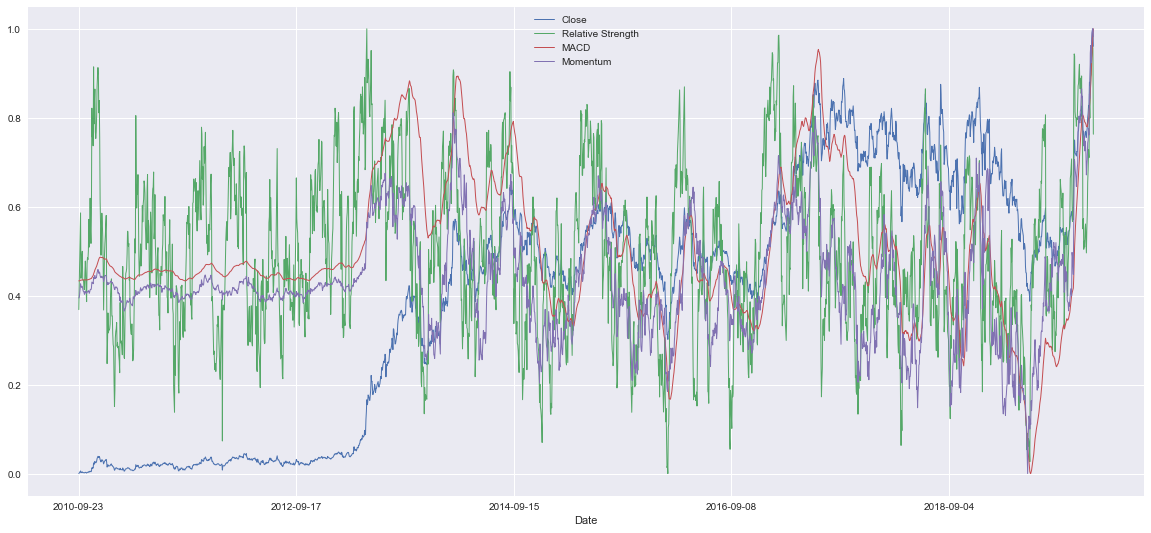

In [330]:
normalized_df['Close'].plot(label='Close')
# normalized_df['LogReturn'].plot(label='Return (log)')
# normalized_df['Sentiment Score'].plot(label='Sentiment')
normalized_df['RSI14'].plot(label='Relative Strength')
normalized_df['MACD'].plot(label='MACD')
normalized_df['Intermediate Momentum'].plot(label='Momentum')
plt.legend()
plt.show()

In [331]:
df

,Open,High,Low,Close,Adj Close,Volume,Sentiment Score,LogReturn,RSI14,MACD,Intermediate Momentum
Date,,,,,,,,,,,
2010-09-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.014836,0.696166,0.558820,0.368635,0.433243,0.394692
2010-09-24,0.000145,0.000120,0.000369,0.001313,0.001313,0.012428,0.696166,0.544814,0.423375,0.433200,0.396588
2010-09-27,0.001229,0.001614,0.001352,0.002358,0.002358,0.008101,0.696166,0.591772,0.464732,0.433387,0.403855
2010-09-28,0.002770,0.003252,0.003097,0.004473,0.004473,0.029585,0.696166,0.557686,0.540793,0.433998,0.415324
2010-09-29,0.003132,0.004552,0.004006,0.005883,0.005883,0.049960,0.696166,0.324810,0.586088,0.434844,0.426919
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.944063,0.967965,0.959813,0.971511,0.971511,0.356349,0.544131,0.528913,0.935354,0.920272,0.967899
2019-12-24,0.959914,0.976299,0.966425,0.986169,0.986169,0.214229,0.576854,0.526627,0.950182,0.944611,0.990932
2019-12-26,0.982920,0.995592,1.000000,1.000000,1.000000,0.283852,0.584526,0.492933,0.963490,0.968782,0.996840
